In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, distinct

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///./Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
# Used inspector to view column names and types for 'measurement'
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [8]:
# Used inspector to view column names and types for 'station'
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [11]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fb78b9de3d0>,
 'longitude': -157.8168,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'elevation': 3.0,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1}

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [16]:
# Query to confirm '2017-08-23' is the latest date
session.query(Measurement.date).\
    filter(Measurement.date > '2017-08-22').\
    order_by(Measurement.date).all()

[('2017-08-23'), ('2017-08-23'), ('2017-08-23'), ('2017-08-23')]

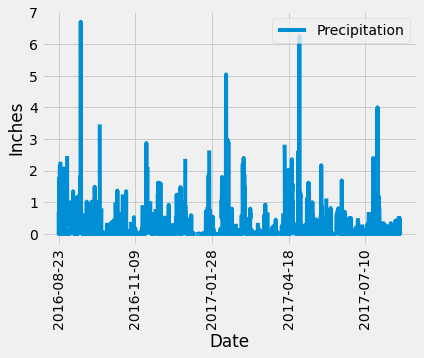

In [17]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_prior = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_prior).\
    order_by(Measurement.date.desc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['date', 'prcp'])
df.rename(columns = {"prcp": "Precipitation"}, inplace=True)
df.set_index('date', inplace=True)
# df.head(10)

# Sort the dataframe by date
df.sort_values(by='date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
df.plot()
plt.xlabel("Date")
plt.ylabel("Inches")
plt.legend(loc='upper right')
plt.xticks(rotation = 90) 
plt.savefig('Rain_by_Date.png')
plt.show()

In [18]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [19]:
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fb78b9de3d0>,
 'longitude': -157.8168,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'elevation': 3.0,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1}

In [20]:
# Design a query to calculate the total number stations in the dataset
session.query(func.count(func.distinct((Measurement.station)))).all()

[(9)]

In [21]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [26]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(Measurement.station, func.min(Measurement.tobs)).all()

[('USC00511918', 53.0)]

In [27]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
min_temp = session.query(func.min(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').\
    group_by(Measurement.station).all()

max_temp = session.query(func.max(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').\
    group_by(Measurement.station).all()

avg_temp = session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').\
    group_by(Measurement.station).all()

print(f"Minimum Temp for station USC00519281: {min_temp[0]}")
print(f"Minimum Temp for station USC00519281: {max_temp[0]}")
print(f"Minimum Temp for station USC00519281: {avg_temp[0]}")

Minimum Temp for station USC00519281: (54.0,)
Minimum Temp for station USC00519281: (85.0,)
Minimum Temp for station USC00519281: (71.66378066378067,)


In [28]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_query = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= '2016-08-23').\
    filter(Measurement.station == 'USC00519281').\
    order_by(Measurement.date.desc()).all()
station_df = pd.DataFrame(station_query, columns=['date', 'tobs'])

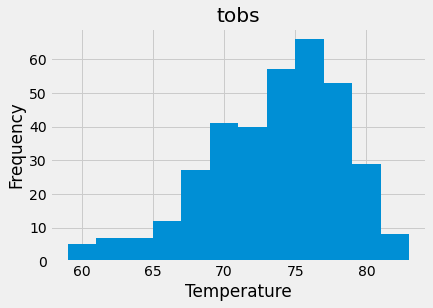

In [29]:
hist = station_df.hist(bins=12)
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.savefig('Station_USC00519281_Histogram.png')
plt.show()

# Close session

In [30]:
# Close Session
session.close()